<a href="https://colab.research.google.com/github/Vani-Kumari/capsuleEndoscopy/blob/main/visionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Set Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

In [50]:
# Prepare the data
num_classes = 8
input_shape = (72, 72, 3)  # Adjust based on your dataset

In [51]:
# paths of  dataset
train_dir = "/content/drive/MyDrive/Capsule Endoscopy Dataset/train_dataset"
test_dir = "/content/drive/MyDrive/Capsule Endoscopy Dataset/Test_Dataset"

In [52]:
batch_size = 32
image_size = (72, 72)

In [53]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)


Found 4009 files belonging to 8 classes.
Found 337 files belonging to 8 classes.


In [54]:
print(f"Train dataset: {train_ds}")
print(f"Test dataset: {test_ds}")

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [55]:
# If you need to convert to numpy arrays:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

In [56]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4009, 72, 72, 3) - y_train shape: (4009,)
x_test shape: (337, 72, 72, 3) - y_test shape: (337,)


In [57]:
# Configure the hyperparameters
learning_rate = 0.0001  # Lower initial learning rate
weight_decay = 0.0001
batch_size = 32  # Adjust based on your GPU memory
num_epochs = 50 # Increase for better training
image_size = 72  # Adjust based on your dataset
patch_size = 6  # Adjust based on your dataset
num_patches = (image_size // patch_size) ** 2
projection_dim = 128  # Increase projection dimension
num_heads = 8  # Increase the number of attention heads
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12  # Increase the number of transformer layers
mlp_head_units = [
    4096,
    2048,
]  # Size of the dense layers of the final classifier

In [58]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [59]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [60]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


(-0.5, 71.5, 71.5, -0.5)

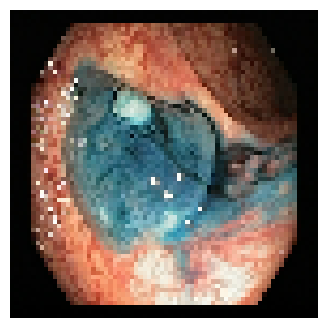

In [61]:
# Display patches for a sample image
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


In [62]:
resized_image = tf.image.resize(image, size=(image_size, image_size))
patches = Patches(patch_size)(tf.expand_dims(resized_image, 0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


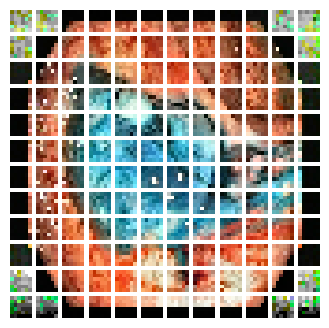

In [63]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(patch_img))
    plt.axis("off")

In [64]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


In [65]:
# Build the ViT model
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [66]:
# Compile, train, and evaluate the model
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    lr_scheduler = keras.callbacks.LearningRateScheduler(
        lambda epoch: learning_rate * 0.1 ** (epoch / 30)
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, lr_scheduler],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [67]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
113/113 [==============================] - 82s 387ms/step - loss: 4.1606 - accuracy: 0.1333 - top-5-accuracy: 0.6325 - val_loss: 2.0867 - val_accuracy: 0.1222 - val_top-5-accuracy: 0.7481 - lr: 1.0000e-04
Epoch 2/50
113/113 [==============================] - 43s 381ms/step - loss: 2.5741 - accuracy: 0.1261 - top-5-accuracy: 0.6480 - val_loss: 2.2351 - val_accuracy: 0.1347 - val_top-5-accuracy: 0.7855 - lr: 9.2612e-05
Epoch 3/50
113/113 [==============================] - 47s 420ms/step - loss: 2.2586 - accuracy: 0.1269 - top-5-accuracy: 0.6344 - val_loss: 2.1396 - val_accuracy: 0.2519 - val_top-5-accuracy: 0.8005 - lr: 8.5770e-05
Epoch 4/50
113/113 [==============================] - 30s 267ms/step - loss: 2.1647 - accuracy: 0.1256 - top-5-accuracy: 0.6145 - val_loss: 2.1746 - val_accuracy: 0.2045 - val_top-5-accuracy: 0.7606 - lr: 7.9433e-05
Epoch 5/50
113/113 [==============================] - 30s 267ms/step - loss: 2.1090 - accuracy: 0.1256 - top-5-accuracy: 0.6231 - val_lo

In [68]:
# Plotting
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

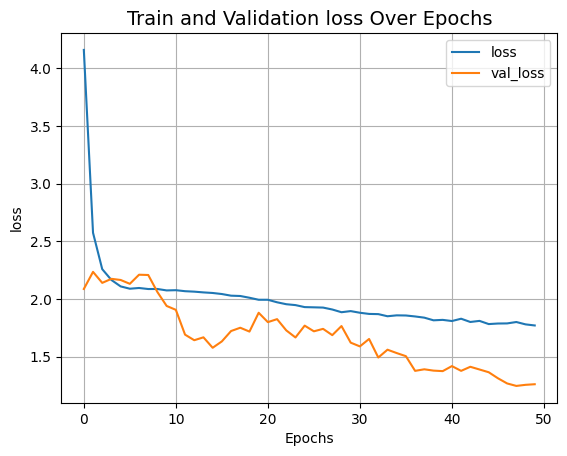

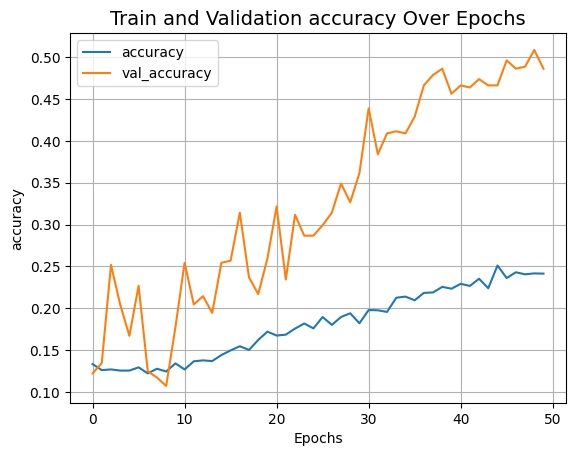

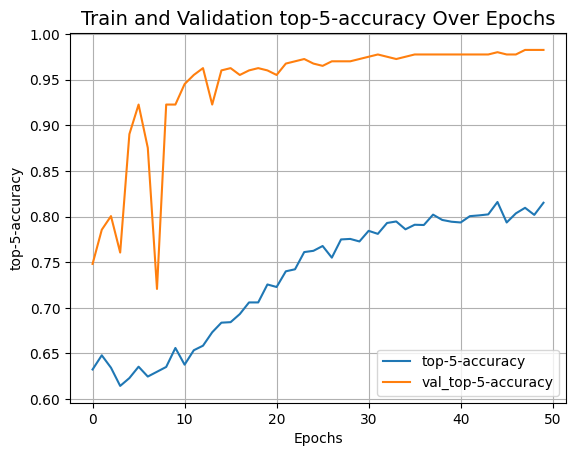

In [69]:
plot_history("loss")
plot_history("accuracy")
plot_history("top-5-accuracy")